In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# Iniciando sessão do PySpark

In [1]:
# Iniciando o ambiente PySpark
import findspark
findspark.init()

In [2]:
# Criando uma instância de SparkSession para iniciar uma sessão Spark
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .master('local[*]')\
    .appName('Análise de dados do SIA')\
    .config('spark.ui.port', '4050')\
    .getOrCreate()

# Carregando Dataset do SIA

In [3]:
PATH_FINAL_DATASET = r'data\003_JOIN_DATASETS\FINAL_DATASET'

In [4]:
df = spark.read.parquet(PATH_FINAL_DATASET)
df.show(5, False)

+-------------+------------+----------+---------+---------+--------+--------+---------+---------+-------+---------+---------+---------+--------+--------+----------+-----------+------------------+-------------------------------+-----------------------------------------+----------------------------------------+------------------------------------------+
|PA_SG_PROC_ID|PA_G_PROC_ID|PA_PROC_ID|PA_CBOCOD|PA_NIVCPL|PA_UFMUN|PA_OBITO|PA_ENCERR|PA_PERMAN|PA_ALTA|PA_TRANSF|PA_QTDAPR|PA_VALAPR|PA_UFDIF|PA_MNDIF|PA_CMP    |DS_PA_UFMUN|DS_PA_NIVCPL      |DS_PA_CBOCOD                   |DS_PA_PROC_ID                            |DS_PA_G_PROC_ID                         |DS_PA_SG_PROC_ID                          |
+-------------+------------+----------+---------+---------+--------+--------+---------+---------+-------+---------+---------+---------+--------+--------+----------+-----------+------------------+-------------------------------+-----------------------------------------+-----------------------

In [5]:
df.printSchema()

root
 |-- PA_SG_PROC_ID: integer (nullable = true)
 |-- PA_G_PROC_ID: integer (nullable = true)
 |-- PA_PROC_ID: integer (nullable = true)
 |-- PA_CBOCOD: string (nullable = true)
 |-- PA_NIVCPL: integer (nullable = true)
 |-- PA_UFMUN: integer (nullable = true)
 |-- PA_OBITO: integer (nullable = true)
 |-- PA_ENCERR: integer (nullable = true)
 |-- PA_PERMAN: integer (nullable = true)
 |-- PA_ALTA: integer (nullable = true)
 |-- PA_TRANSF: integer (nullable = true)
 |-- PA_QTDAPR: integer (nullable = true)
 |-- PA_VALAPR: double (nullable = true)
 |-- PA_UFDIF: integer (nullable = true)
 |-- PA_MNDIF: integer (nullable = true)
 |-- PA_CMP: date (nullable = true)
 |-- DS_PA_UFMUN: string (nullable = true)
 |-- DS_PA_NIVCPL: string (nullable = true)
 |-- DS_PA_CBOCOD: string (nullable = true)
 |-- DS_PA_PROC_ID: string (nullable = true)
 |-- DS_PA_G_PROC_ID: string (nullable = true)
 |-- DS_PA_SG_PROC_ID: string (nullable = true)



In [6]:
# Criando uma view para executar comandos SQL
df.createOrReplaceTempView("VW_SIA")

# Desafio 1: Análise do SIA em Pernambuco: Procedimentos, Complexidade e Profissionais

Gráfico de Barras de Procedimentos por Tipo de Profissional: Crie um gráfico de barras que mostre a contagem de procedimentos realizados por diferentes tipos de profissionais de saúde. Isso pode ajudar a identificar se há procedimentos realizados por profissionais não especializados.

In [43]:
# Quantidade de procedimentos distintos realizados por profissional
SQL_101 = '''
SELECT PA_CBOCOD
     , DS_PA_CBOCOD
     , COUNT(PA_PROC_ID) AS QTD_PROC_REALIZADOS
  FROM (
       SELECT PA_CBOCOD
            , DS_PA_CBOCOD
            , PA_PROC_ID
            , DS_PA_PROC_ID
            , COUNT(1)
         FROM VW_SIA
        GROUP BY PA_CBOCOD
              , DS_PA_CBOCOD
              , PA_PROC_ID
              , DS_PA_PROC_ID
       )
 GROUP BY PA_CBOCOD
        , DS_PA_CBOCOD
 ORDER BY COUNT(PA_PROC_ID) DESC
'''

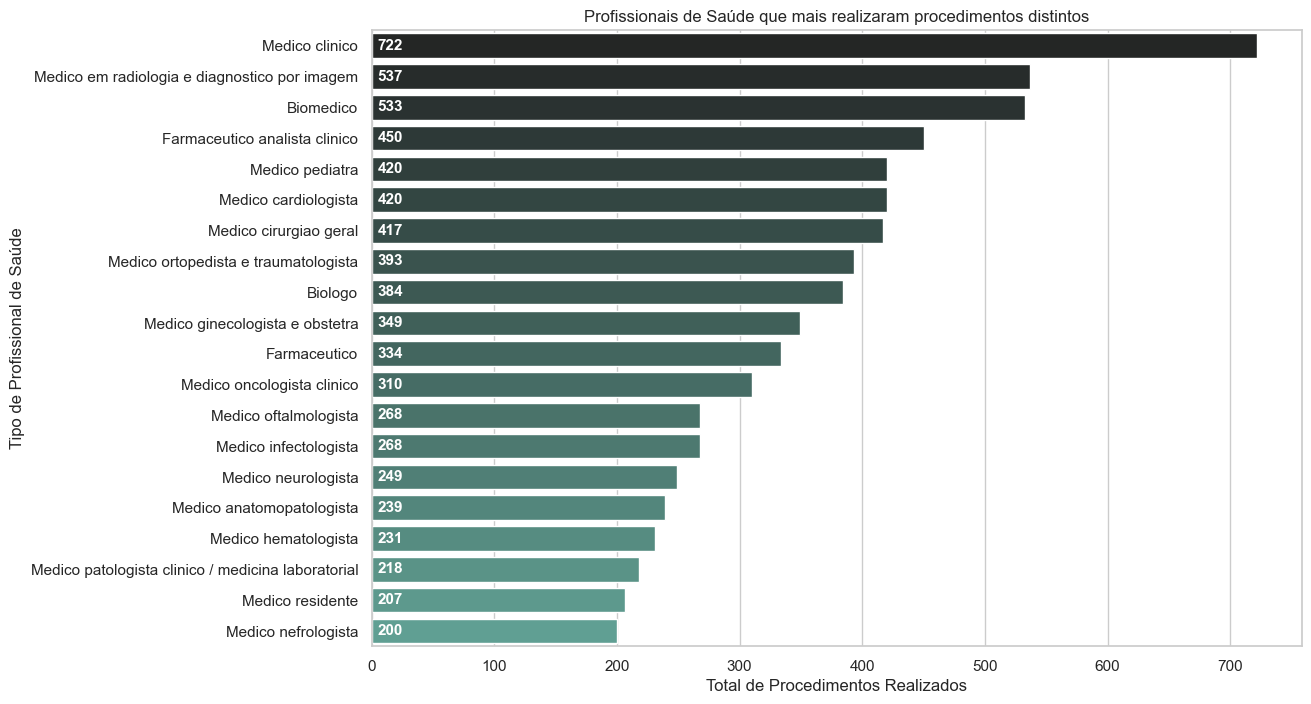

In [89]:
num_results = 20

plt.figure(figsize=(12, 8))
colors = sns.color_palette("dark:#5A9", n_colors = num_results)

ax = sns.barplot(x = "QTD_PROC_REALIZADOS", y = "DS_PA_CBOCOD",
                 data = spark.sql(SQL_101).limit(num_results).toPandas(),
                 palette = colors)

for p in ax.patches:
    width = p.get_width()
    plt.text(5, p.get_y() + p.get_height() / 2, f"{int(width)}"
             , ha = "left", va = "center"
             , fontsize = 11, fontweight = "bold", color = "white")

plt.xlabel("Total de Procedimentos Realizados")
plt.ylabel("Tipo de Profissional de Saúde")
plt.title("Profissionais de Saúde que mais realizaram procedimentos distintos")

plt.show()


Gráfico de Pizza de Complexidade do Procedimento: Use um gráfico de pizza para mostrar a distribuição da complexidade dos procedimentos realizados. Isso pode ajudar a identificar se procedimentos não especializados tendem a ser de menor complexidade.

Gráfico de Barras Empilhadas por Complexidade e Profissional: Crie um gráfico de barras empilhadas que mostre a distribuição de procedimentos por complexidade, segmentada por diferentes tipos de profissionais. Isso pode ajudar a visualizar se procedimentos não especializados estão concentrados em determinadas categorias de complexidade.

Gráfico de Linhas Temporais por Profissional: Se houver uma variável de data, crie um gráfico de linhas que mostre como a quantidade de procedimentos realizados por diferentes tipos de profissionais evolui ao longo do tempo.

# Desafio 2: Análise de Valores e Quantidades em Atendimentos de Saúde em Pernambuco

Gráfico de Dispersão Valor x Quantidade: Crie um gráfico de dispersão onde o eixo x representa a quantidade de atendimentos realizados e o eixo y representa o valor pago. Cada ponto no gráfico representa um município. Isso pode ajudar a identificar municípios que estão recebendo valores inconsistentes em relação à quantidade de atendimentos.

Mapa de Calor de Diferença de Valor: Use um mapa de calor para mostrar a diferença entre o valor pago e o valor esperado (com base na quantidade de atendimentos) em diferentes municípios. Isso pode destacar os municípios com variações significativas.

Gráfico de Barras de Municípios com Inconsistências: Crie um gráfico de barras que liste os municípios com as maiores inconsistências entre valor e quantidade de atendimentos. Isso pode ajudar a identificar os casos mais problemáticos.

Box Plot de Valores por Município: Use um box plot para visualizar a distribuição dos valores pagos em diferentes municípios. Isso pode revelar discrepâncias nos valores.

Gráfico de Linhas Temporais por Município: Se houver uma variável de data, crie um gráfico de linhas que mostre como a quantidade de atendimentos e os valores pagos variaram ao longo do tempo para diferentes municípios.

# Desafio 3: Análise da Distribuição de Valores, Mortalidade e Variáveis Temporais em Procedimentos de Saúde em Pernambuco

Gráfico de Correlação de Variáveis

Histograma da Distribuição dos Valores Pagos: Crie um histograma para visualizar a distribuição dos valores pagos por procedimento. Isso pode ajudar a identificar tendências na distribuição de custos.

Gráfico de Série Temporal de Atendimentos: Se houver dados de datas, crie um gráfico de série temporal que mostre como o número de atendimentos varia ao longo do tempo. Isso pode revelar tendências sazonais ou variações ao longo dos anos.

Gráfico de Pizza de Óbitos vs. Altas: Crie um gráfico de pizza para mostrar a proporção de procedimentos que resultaram em óbitos em comparação com aqueles que resultaram em altas. Isso pode fornecer insights sobre a mortalidade em relação aos procedimentos.

Gráfico de Pizza da Diferença de Município/UF por Complexidade: Use um gráfico de pizza para mostrar a proporção de pacientes que residem no mesmo município/UF do estabelecimento versus aqueles que residem em municípios/UF diferentes, segmentado por complexidade do procedimento.

Gráfico de Linhas Temporais da Diferença de Município: Se houver dados de datas, crie um gráfico de linhas que mostre como a diferença no município de residência do paciente em relação ao estabelecimento varia ao longo do tempo.